In [1]:
from transitleastsquares import transitleastsquares
# main.py
import sys
import os
import numpy as np
import matplotlib.pyplot as plt


# Use the absolute path to your project root directory instead of __file__
base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(base_dir)


In [2]:
from sim.SimulateAndFlux import flux_data_from_params


In [3]:
# Stellar parameters: [radius, mass]
radius_wasp148a = 0.912 * 696.34e6 / 1.496e11
mass_wasp148a = 0.9540 * 2e30 / 6e24

stellar_params = [radius_wasp148a, mass_wasp148a]  # Based on WASP 148
radius_wasp148_b = 8.47 * 6.4e6 / 1.496e11
radius_wasp148_c = (
    9.4 * 6.4e6 / 1.496e11
)  # assumed similar densities as no values for radius

eta1 = 0.3
eta2 = 0.4
# planet_params =[ [ eta,   a,     P,   e,               inc, omega, OHM, phase_lag ] ]
planet_params = np.array(
    [
        [eta1, 0.08215, 8.803809, 0.208, np.radians(90), 0, 0, 0, 0.287],
        # [eta2, 0.2044, 17, 0.1809, np.radians(90), 0, 0, np.pi / 4, 0.392]
    ]
)
# True inclinations are 89.3 and 104.9 +- some

num_samples = 60000
number_max_period = 4
times_input = np.linspace(0, 2 * 20, 60000)  # Three orbital periods for planet 1

planet_params_analytical = planet_params[:, :-1]
output_analytical = flux_data_from_params(
    stellar_params=stellar_params, planet_params=planet_params_analytical, times=times_input, analytical_bool=True
)

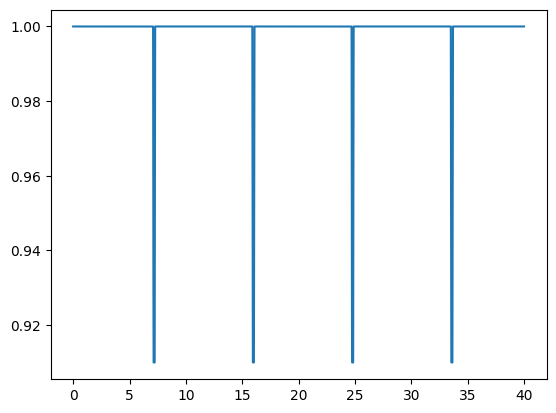

In [4]:
plt.plot(times_input, output_analytical)

In [5]:
from MCMC.main import add_gaussian_error

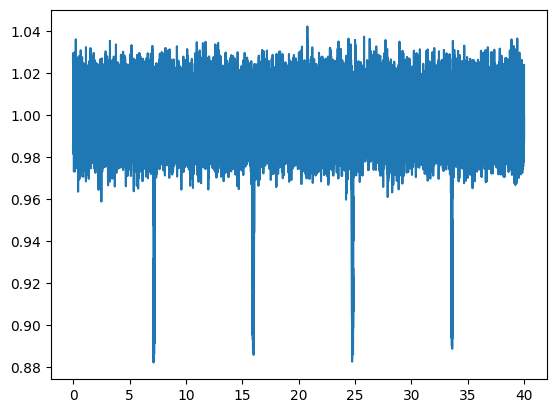

In [6]:
sigma_n = 1e-2
fluxes = add_gaussian_error(output_analytical, 0, sigma_n)
plt.plot(times_input, fluxes)

In [16]:
model = transitleastsquares(times_input, fluxes)
results = model.power()
plt.figure()
plt.plot(
    results.model_folded_phase,
    results.model_folded_model,
    color='red')
plt.scatter(
    results.folded_phase,
    results.folded_y,
    color='blue',
    s=10,
    alpha=0.5,
    zorder=2)
plt.xlim(0.49, 0.51)
plt.xlabel('Phase')
plt.ylabel('Relative flux');

Transit Least Squares TLS 1.32 (5 Apr 2024)
Creating model cache for 41 durations
Searching 59999 data points, 3887 periods from 0.601 to 20.0 days
Using all 8 CPU threads


  1%|▏         | 58/3887 periods | 00:03<01:08 

KeyboardInterrupt: 

Text(0, 0.5, 'Normalized flux')

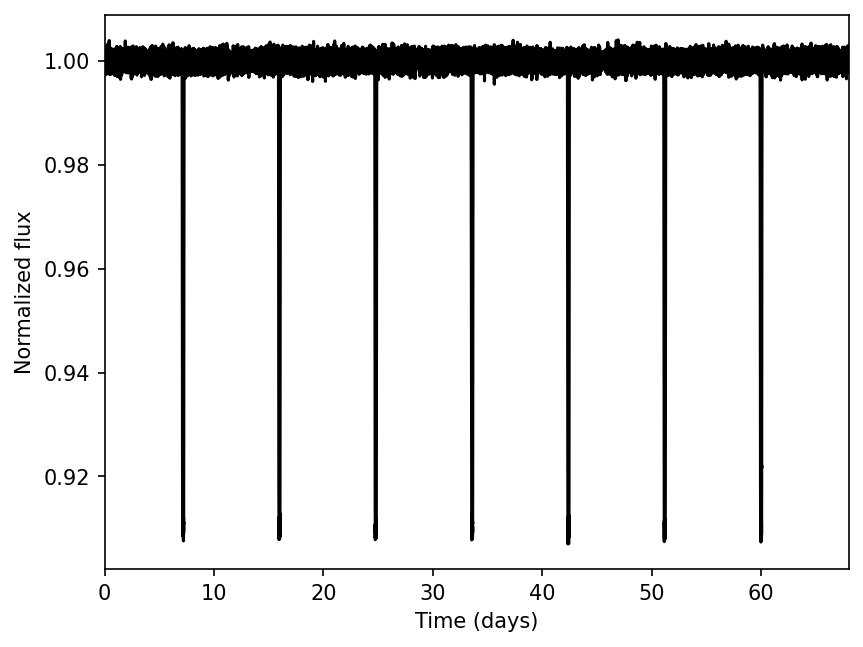

In [ ]:
from transitleastsquares import transit_mask, cleaned_array
intransit = transit_mask(times_input, results.period, 2*results.duration, results.T0)
y_second_run = fluxes[~intransit]
t_second_run = times_input[~intransit]
t_second_run, y_second_run = cleaned_array(t_second_run, y_second_run)
from matplotlib import rcParams; rcParams["figure.dpi"] = 150
plt.figure()
ax = plt.gca()
ax.plot(t_second_run, y_second_run, "k")
ax.set_xlim(times_input.min(), times_input.max())
ax.set_xlabel("Time (days)")
ax.set_ylabel("Normalized flux")

Transit Least Squares TLS 1.32 (5 Apr 2024)
Creating model cache for 44 durations
Searching 59080 data points, 7090 periods from 0.602 to 33.999 days
Using all 8 CPU threads


100%|██████████| 7090/7090 periods | 01:55<00:00


Searching for best T0 for period 8.80598 days


100%|██████████| 6090/6090 [00:11<00:00, 534.24it/s]


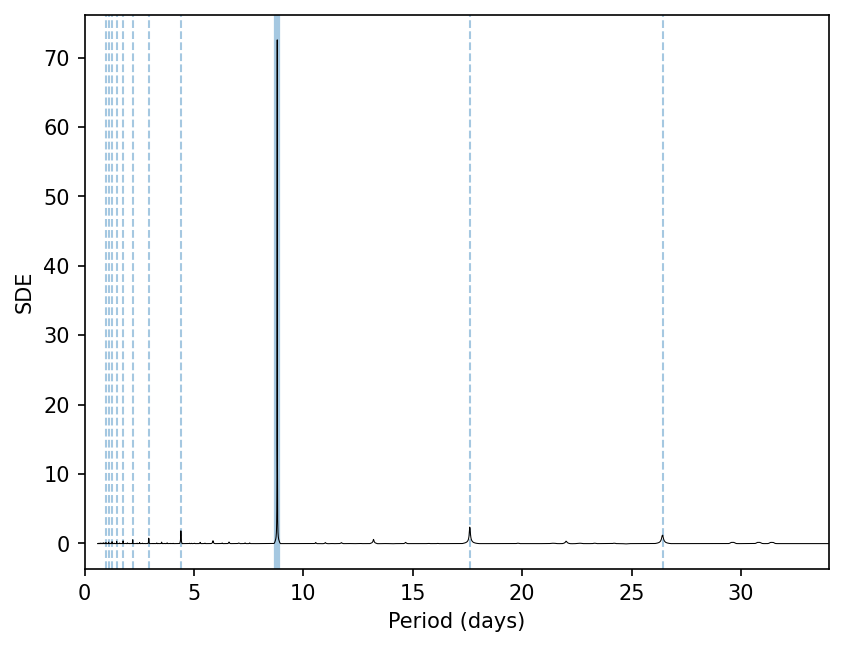

In [ ]:
model_second_run = transitleastsquares(t_second_run, y_second_run)
results_second_run = model_second_run.power()
plt.figure()
ax = plt.gca()
ax.axvline(results_second_run.period, alpha=0.4, lw=3)
plt.xlim(np.min(results_second_run.periods), np.max(results_second_run.periods))
for n in range(2, 10):
    ax.axvline(n*results_second_run.period, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(results_second_run.period / n, alpha=0.4, lw=1, linestyle="dashed")
plt.ylabel(r'SDE')
plt.xlabel('Period (days)')
plt.plot(results_second_run.periods, results_second_run.power, color='black', lw=0.5)
plt.xlim(0, max(results_second_run.periods));

In [ ]:
plt.figure()
plt.plot(
    results_second_run.model_folded_phase,
    results_second_run.model_folded_model,
    color='red')
plt.scatter(
    results_second_run.folded_phase,
    results_second_run.folded_y,
    color='blue',
    s=10,
    alpha=0.5,
    zorder=2)
# plt.xlim(0.49, 0.51)
# plt.ylim(0.9985, 1.0003)
plt.xlabel('Phase')
plt.ylabel('Relative flux')

plt.figure()
in_transit = transit_mask(
    t_second_run,
    results_second_run.period,
    results_second_run.duration,
    results_second_run.T0)
plt.scatter(
    t_second_run[in_transit],
    y_second_run[in_transit],
    color='red',
    s=2,
    zorder=0)
plt.scatter(
    t_second_run[~in_transit],
    y_second_run[~in_transit],
    color='blue',
    alpha=0.5,
    s=2,
    zorder=0)
plt.plot(
    results_second_run.model_lightcurve_time,
    results_second_run.model_lightcurve_model, alpha=0.5, color='red', zorder=1)
# plt.xlim(min(times_input), max(times_input))
# plt.ylim(min(fluxes), max(fluxes))
plt.xlabel('Time (days)')
plt.ylabel('Relative flux');

NameError: name 'results_second_run' is not defined

<Figure size 640x480 with 0 Axes>

In [7]:
def run_tls(data: np.ndarray, times_input: np.ndarray, limb_darkening_model: str, limb_darkening_coefficients: list, plot_bool = False):
    """
    """
    from transitleastsquares import transitleastsquares, transit_mask, cleaned_array
    model = transitleastsquares(times_input, data)
    results = model.power(limb_dark = limb_darkening_model, u = limb_darkening_coefficients)

    period = results.period
    transit_times = results.transit_times
    transit_depth = results.depth
    duration = results.duration
    SDE = results.SDE
    t_0 = results.T0

    output_dict = {"Period": period, "Transit_times": transit_times, "Transit_depth": transit_depth, "Duration": duration, "SDE": SDE, "t_0": t_0}

    intransit = transit_mask(times_input, results.period, 2*results.duration, results.T0)
    y_second_run = data[~intransit]
    t_second_run = times_input[~intransit]
    t_second_run, y_second_run = cleaned_array(t_second_run, y_second_run)

    if plot_bool:
        plt.figure(1)
        from transitleastsquares import transit_mask
        plt.figure()
        in_transit = transit_mask(
            times_input,
            results.period,
            results.duration,
            results.T0)
        plt.scatter(
            times_input[in_transit],
            data[in_transit],
            color='red',
            s=2,
            zorder=0)
        plt.scatter(
            times_input[~in_transit],
            data[~in_transit],
            color='blue',
            alpha=0.5,
            s=2,
            zorder=0)
        plt.plot(
            results.model_lightcurve_time,
            results.model_lightcurve_model, alpha=0.5, color='red', zorder=1)
        plt.xlim(min(times_input), max(times_input))
        plt.ylim(min(data*0.98), max(data*1.02))
        plt.xlabel('Time (days)')
        plt.ylabel('Relative flux')
        plt.show()

        plt.figure(2)
        ax = plt.gca()
        ax.axvline(results.period, alpha=0.4, lw=3)
        plt.title(f"Power spectrum of the data with period {results.period}")
        plt.xlim(np.min(results.periods), np.max(results.periods))
        for n in range(2, 10):
            ax.axvline(n*results.period, alpha=0.4, lw=1, linestyle="dashed")
            ax.axvline(results.period / n, alpha=0.4, lw=1, linestyle="dashed")
        plt.ylabel(r'SDE')
        plt.xlabel('Period (days)')
        plt.plot(results.periods, results.power, color='black', lw=0.5)
        plt.xlim(0, max(results.periods))
        plt.show()
                


    return y_second_run, t_second_run, output_dict


def search_for_transits(data: np.ndarray, times_input: np.ndarray, limb_darkening_model: str, limb_darkening_coefficients: list, signal_detection_efficiency: float = 10.0, plot_bool = False):
    """
    """
    # list of dictionaries: [dict([Period, transit_times, transit_depth, duration, SDE])]
    results_list = [] 
    # Run TLS on the data
    current_signal_detection_efficiency = 1000
    count = 0 
    while current_signal_detection_efficiency > signal_detection_efficiency:
        count += 1 
        data, times_input, dictionary_entry = run_tls(data, times_input, limb_darkening_model, limb_darkening_coefficients, plot_bool)

        current_signal_detection_efficiency = dictionary_entry["SDE"]

        if current_signal_detection_efficiency < signal_detection_efficiency:
            print(f"{len(results_list)} transits have been found with a signal detection efficiency of {signal_detection_efficiency}")
            break
        print(f"Found a planet with SDE of {current_signal_detection_efficiency} and period of {dictionary_entry["Period"]}")
        results_list.append(dictionary_entry)
        if count == 1:
            break 
    
    background_mean = np.mean(data)
    background_std = np.std(data)
    
    return results_list, background_mean, background_std



In [12]:
from MCMC.main import prepare_arrays_for_mcmc, inclination_checker, gaussian_error_ln_likelihood
from MCMC.mcmc import MCMC
from transitleastsquares import transitleastsquares, transit_mask, cleaned_array
def obtain_priors(data, times_input, limb_darkening_model, limb_darkening_coefficients, signal_detection_efficiency, stellar_params, plot_bool = False, duration_buffer = 4, num_iterations = 100_00):
    """
    """
    results_list, background_mean, background_std = search_for_transits(data, times_input, limb_darkening_model, limb_darkening_coefficients, signal_detection_efficiency, plot_bool)

    # Isolate each tranist and run through MCMC to get priors

    radius_star = stellar_params[0]
    initial_values = np.zeros((len(results_list), 8))
    standard_devs = np.zeros((len(results_list), 8))
    for i in range(len(results_list)):

        period = results_list[i]["Period"]
        transit_times = results_list[i]["Transit_times"]
        transit_depth = results_list[i]["Transit_depth"]
        duration = results_list[i]["Duration"]
        t_0 = results_list[i]["t_0"]

        in_transit = transit_mask(
            times_input,
            results_list[i]["Period"],
            results_list[i]["Duration"]*duration_buffer,
            results_list[i]["t_0"]
            )
        # results_list[i]["Transit_times"] = results_list[i]["Transit_times"] - results_list[i]["T0"]
        test_fluxes = np.zeros_like(times_input)
        test_fluxes[in_transit] = fluxes[in_transit]

        zeros = np.zeros_like(times_input)
        fuzzy_ones = add_gaussian_error(zeros, background_mean, background_std)

        # plt.plot(times_input, fuzzy_ones)
        test_fluxes[~in_transit] = fuzzy_ones[~in_transit]

        if plot_bool:
            plt.figure()
            plt.title(f"Transit {i}")
            plt.plot(times_input, test_fluxes)
            plt.show()

        eta = np.sqrt(1-transit_depth)
        phase_lag = 2*np.pi*t_0/period - 3* np.pi/2
        a_estimate = radius_star*(1+eta) * period/(np.pi * duration) # See Msci proj workbook 1 page 184-185

        param_names = np.array([
            [r"$\eta$", "a", "P", "e", "inc", "omega", "big_ohm", "phase_lag", "mass"]])
        
        initial_params = np.array([
            [eta, a_estimate, period, 0, np.radians(90), 0, 0, phase_lag, 0]])
        
        param_bounds = np.array([
            [(0.02, 0.7), (0.04, 1), (0, 1e10), (0, 0.6), (np.radians(83), np.pi), (-np.pi/2, np.pi/2), (-np.pi/2, np.pi/2), (-np.pi/2, np.pi/2), (0, 6000)]])
        
        true_vals = np.array([
            [0.1, 0.08215, 8.803809, 0.208, np.radians(90), 0, 0, 0, 0.287],
            ])
        
        proposal_std = np.array([
            [1e-2, 1e-2, 1e-2, 0, 1e-2, 1e-2, 0, 1e-2, 0],  # Planet 1 
            ])
        
        eta1 = 0.3
        # planet_params =[ [ eta,   a,     P,   e,               inc, omega, OHM, phase_lag ] ]
        true_vals = np.array(
            [
                [eta1, 0.08215, 8.803809, 0.208, np.radians(90), 0, 0, 0, 0.287],
                # [eta2, 0.2044, 17, 0.1809, np.radians(90), 0, 0, np.pi / 4, 0.392]
            ]
        )
        
        analytical_bool = True
        param_names, true_vals, initial_params, proposal_std, param_bounds = prepare_arrays_for_mcmc(param_names, 
                                                                                                        true_vals, 
                                                                                                        initial_params, 
                                                                                                        proposal_std, 
                                                                                                        param_bounds,
                                                                                                        analytical_bool)
        
        def likelihood_fn(params):
            return gaussian_error_ln_likelihood(
                fluxes,
                None,
                lambda params: flux_data_from_params(
                    stellar_params, params, times_input, analytical_bool=analytical_bool
                ),
                params,
                sigma_n,
            )


        mcmc = MCMC(
            fluxes,
            initial_params,
            param_bounds,
            proposal_std,
            param_names=param_names,
            likelihood_func=likelihood_fn,
            inclination_rejection_func=lambda proposals: inclination_checker(proposals, radius_star),
            max_cpu_nodes=8,
        )

        mcmc.metropolis_hastings(num_iterations)
        mcmc.chain_to_plot_and_estimate(true_vals, manual_burn_in_idx = 500)
        

        initial_values[i] = np.mean(mcmc.chain[mcmc.burn_in_index:], axis=(0, 1))
        standard_devs[i] = np.std(mcmc.chain[mcmc.burn_in_index:], axis=(0, 1))



        print(f"For planet {i} Initial values: {initial_values}")
        print(f"For planet {i} Standard deviations: {standard_devs}")

        plt.title("Difference between true and estimated fluxes")
        plt.xlabel("Time")
        plt.ylabel("Difference in Fluxes")
        plt.plot(
            times_input,
            flux_data_from_params(
                stellar_params, mcmc.chain[-1], times_input, analytical_bool=True
            )
            - flux_data_from_params(
                stellar_params, true_vals, times_input, analytical_bool=True
            ),
        )
        plt.show()
        # plt.close()
            
    return initial_values, standard_devs
        



            

Transit Least Squares TLS 1.32 (5 Apr 2024)
Creating model cache for 41 durations
Searching 59999 data points, 3887 periods from 0.601 to 20.0 days
Using all 8 CPU threads


100%|██████████| 3887/3887 periods | 00:54<00:00


Searching for best T0 for period 8.80075 days


100%|██████████| 6888/6888 [00:10<00:00, 669.81it/s]


<Figure size 640x480 with 0 Axes>

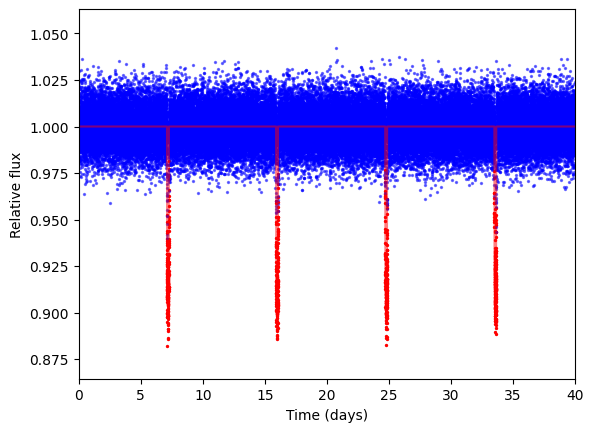

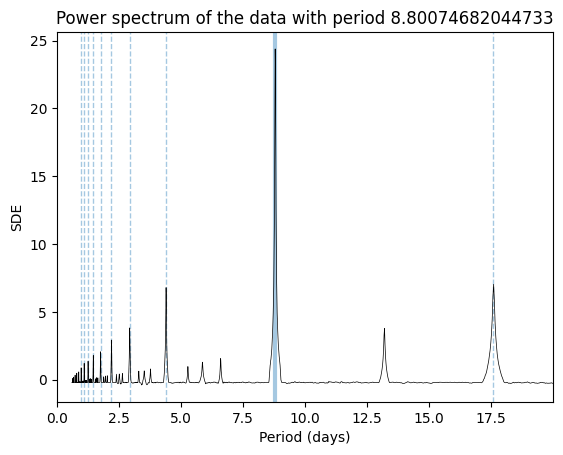

Found a planet with SDE of 24.391636395534487 and period of 8.80074682044733


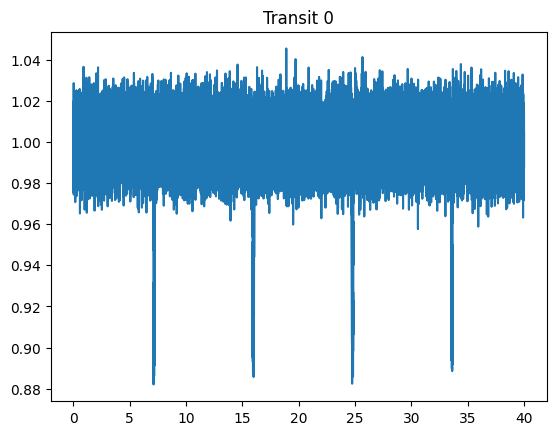

MCMC Run :  98%|█████████▊| 9849/10000 [00:50<00:00, 194.49it/s]


acceptance_rate=0.9334933493349334
MCMC sampling completed.
Estimated $\eta$: 2.572e-01 , true $\eta$: 0.3
Estimated a: 4.939e-01 , true a: 0.08215
Estimated P: 9.012e+00 , true P: 8.803809
Estimated inc: 1.822e+00 , true inc: 1.5707963267948966
Estimated omega: -2.413e-01 , true omega: 0.0
Estimated phase_lag: 5.207e-02 , true phase_lag: 0.0


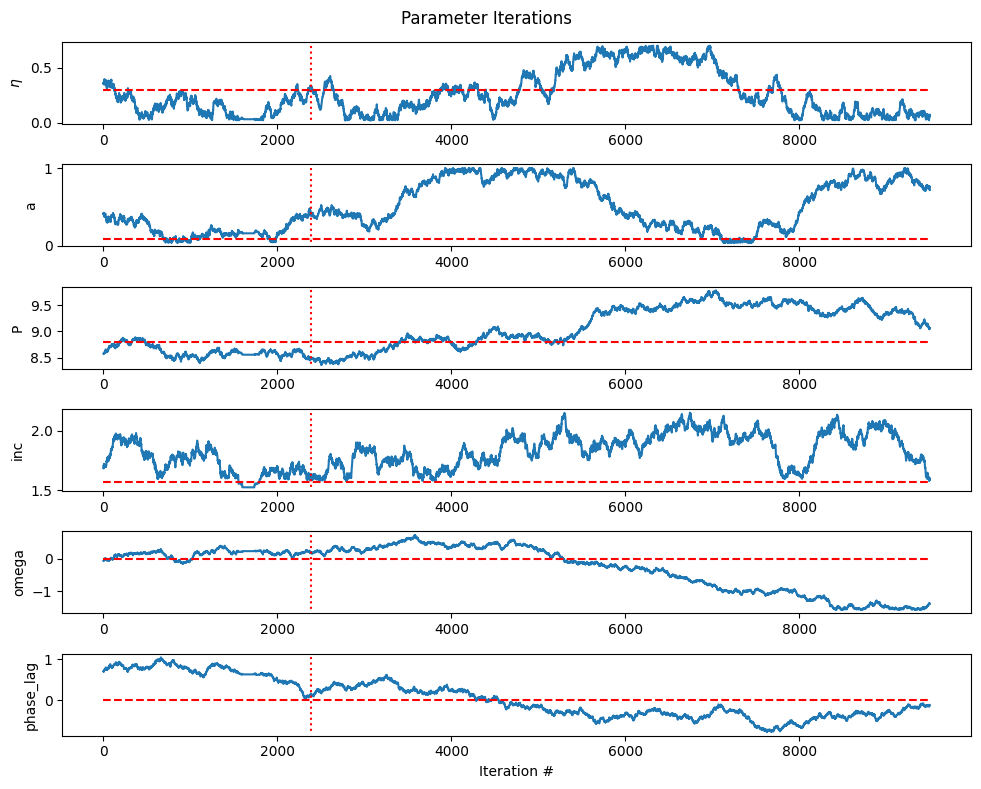

For planet 0 Initial values: [[ 0.28508364  0.56834748  9.10696025  0.          1.84132155 -0.33843331
   0.         -0.12784758]]
For planet 0 Standard deviations: [[0.20711584 0.30598302 0.39197388 0.         0.14379522 0.72481336
  0.         0.34413176]]


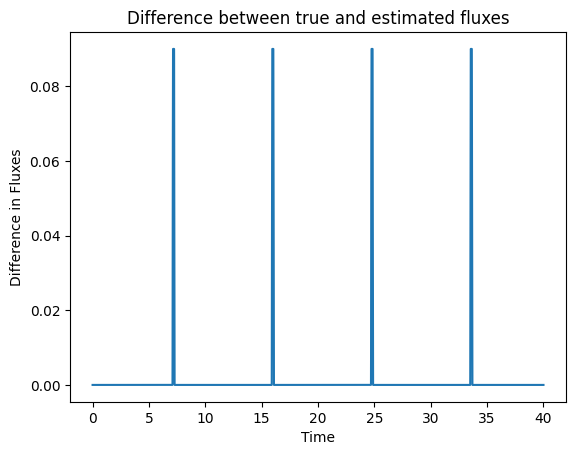

In [13]:
initial_vals, standard_devs = obtain_priors(fluxes, times_input, "linear", [0], 10.0, stellar_params, plot_bool = True, duration_buffer = 4, num_iterations = 100_00)

In [ ]:
output = search_for_transits(fluxes, times_input, "linear", [0], plot_bool=True)

Transit Least Squares TLS 1.32 (5 Apr 2024)
Creating model cache for 41 durations
Searching 59999 data points, 3887 periods from 0.601 to 20.0 days
Using all 8 CPU threads


KeyboardInterrupt: 

In [15]:
print(output[0])

{'Period': 17.005514606178263, 'Transit_times': [11.590698286786926, 28.59621289296519, 45.60172749914345, 62.60724210532172], 'Transit_depth': 0.8569586515960295, 'Duration': 0.11842767274410233, 'SDE': 30.637348320469265}


In [22]:
print(np.mean(fluxes[0:1000]))
print(np.std(fluxes[0:1000]))


0.9999965576289748
0.0010172916056939998


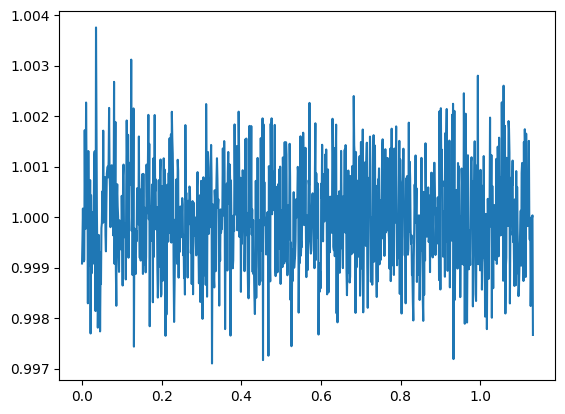

In [20]:
plt.plot(times_input[0:1000],fluxes[0:1000])

In [62]:
output[0]

{'Period': 17.005514606178263,
 'Transit_times': [11.590698286786926,
  28.59621289296519,
  45.60172749914345,
  62.60724210532172],
 'Transit_depth': 0.8569586515960295,
 'Duration': 0.11842767274410233,
 'SDE': 30.637348320469265,
 't_0': 11.590124828674702}

In [54]:
from transitleastsquares import transit_mask
in_transit = transit_mask(
    times_input,
    output[0]["Period"],
    output[0]["Duration"]*4,
    output[0]["t_0"]
    )

In [58]:
# plt.plot(times_input[in_transit], fluxes[in_transit], "x")
test_fluxes = np.zeros_like(times_input)

test_fluxes[in_transit] = fluxes[in_transit]

zeros = np.zeros_like(times_input)
mean = (np.mean(fluxes[0:1000]))
std = (np.std(fluxes[0:1000]))
fuzzy_ones = add_gaussian_error(zeros, mean, std)

# plt.plot(times_input, fuzzy_ones)
test_fluxes[~in_transit] = fuzzy_ones[~in_transit]


(11.5, 11.7)

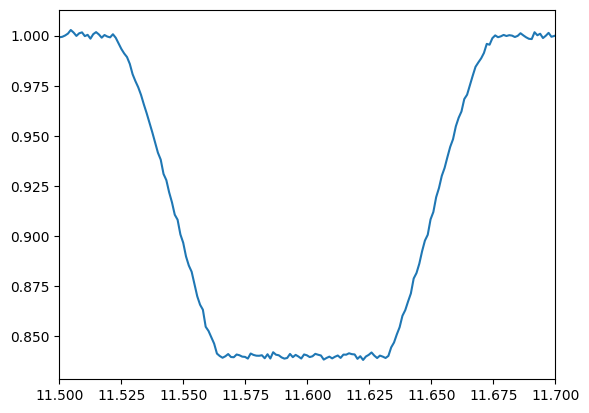

In [69]:
plt.plot(times_input, test_fluxes)
plt.xlim(11.5,11.7)

Run MCMC on this